In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy
import os
import time
import arff
from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from numpy.linalg import inv
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

 This is a auto regressive model on the input features

 x_t = A @ x_t1 + B @ u_t1 + w_t
 y_t = C @ x_t + v_t

 u -> Explanatory variables
 x -> current input plus historical inputs
 C -> regression coefficients

 Note that A should be very small, B could be the PCA transformation matrix.
 And because of that, y should also be centered.

In [31]:
# ENEOS Dataset
df_long = pd.read_excel("C:/Users\liuwe\Desktop\Daily\Research\ENEOS\Data_3/New_LSR/211213_根岸LSR平衡還流沸点データ.xlsx",
                     sheet_name='DataBase(432)', header=3, index_col=0, skiprows=range(4,5))
df_short= pd.read_excel("C:/Users\liuwe\Desktop\Daily\Research\ENEOS\Data_3/New_LSR/211213_根岸LSR平衡還流沸点データ.xlsx",
                     sheet_name='DataBase(122)', header=3, index_col=0, skiprows=range(4,5))
df_train, df_test = df_long.iloc[:315,:], df_short
y_train, date_train = df_train.pop('bp').values, df_train.pop('Date').values
y_test, date_test = df_test.pop('bp').values, df_test.pop('Date')

In [288]:
# Water quality prediction dataset
import scipy.io
mat_data = scipy.io.loadmat('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Water quality prediction/water_dataset.mat')
variable_list = scipy.io.whosmat('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Water quality prediction/water_dataset.mat')

columns = ['Water conductance max', 'Water PH max', 'Water PH min',
           'Water conductance min', 'Water conductance mean', 'Oxygen max',
           'Oxygen mean', 'Oxygen min', 'Temperature mean',
           'Temperature min', 'Temperature max']
tr_length, te_length = mat_data['X_tr'][0][:].shape[0], mat_data['X_te'][0][:].shape[0]
df_variables_tr = pd.DataFrame(index=range(tr_length), columns=columns)
df_variables_te = pd.DataFrame(index=range(te_length), columns=columns)
# y_tr, y_te = mat_data['Y_tr'][34,:], mat_data['Y_te'][34,:]
y_tr, y_te = mat_data['Y_tr'].mean(axis=0), mat_data['Y_te'].mean(axis=0)

for i in range(tr_length):
    # mat_data['X_tr'][0][i][34,:] # The 35th location, forming a single group
    # mat_data['X_tr'][0][i].mean(axis=0) # mean values of all 37 locations
    df_variables_tr.iloc[i,:] = mat_data['X_tr'][0][i].mean(axis=0)

for i in range(te_length):
    # mat_data['X_te'][0][i][34,:] # The 35th location, forming a single group
    # mat_data['X_te'][0][i].mean(axis=0) # mean values of all 37 locations
    df_variables_te.iloc[i,:] = mat_data['X_te'][0][i].mean(axis=0)

X_train, X_test = df_variables_tr.values.astype(float), df_variables_te.values.astype(float)

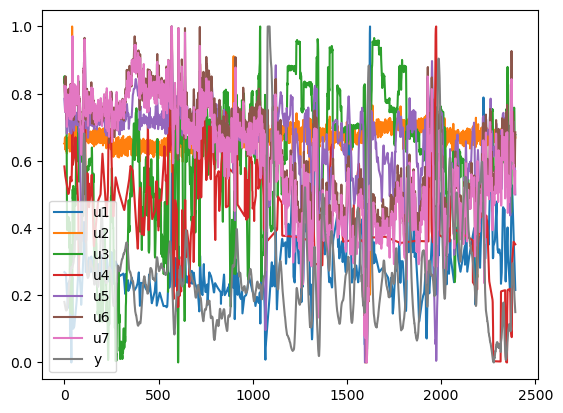

In [2]:
# Debutanizer Column data set
df = pd.read_csv('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Debutanizer Column\debutanizer_data.txt', 
                 delimiter='\s+', header=None, skiprows=3, names=['u1','u2','u3','u4','u5','u6','u7','y'],)
df.plot() # already normalized data
y_column = df.pop('y').values
X_column = df.values
split = 2000
X_train, X_test = X_column[:split,:], X_column[split:,:]
y_train, y_test = y_column[:split], y_column[split:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# Melt index prediction
MI1 = pd.read_csv('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Melt Index\M1.txt',header=0,index_col=0,sep='\t')
MI2 = pd.read_csv('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Melt Index\M2.txt',header=0,sep='\t')
MI3 = pd.read_csv('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Melt Index\M3.txt',header=0,sep='\t')
MI1 = MI1.reset_index(drop=True)
raw_data = pd.concat([MI1.iloc[:,:12], MI2.iloc[:,:8], MI3], axis=1)
raw_data.drop(314, inplace=True)
target = raw_data.pop(raw_data.columns[-1]).values
X_train, X_test, y_train, y_test = train_test_split(raw_data.values[:,12:], target, train_size=249, shuffle=False)
# Already in the range of 0~1 and include a constant column
print(X_train.shape, X_test.shape)

(249, 17) (81, 17)


In [41]:
# Gas Turbine CO and NOx emission data set
df_gas = pd.read_csv('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Gas Turbine CO and NOx Emission Data Set\gt_2012.csv')
resample_fre = round(df_gas.shape[0]/365)
df_gas_day = df_gas[::20].iloc[:365,:].reset_index(drop=True)
y_NO = df_gas_day.pop('NOX').values
y_CO = df_gas_day.pop('CO').values
X_gas = df_gas_day.values
split = 300
X_train, X_test = X_gas[:split,:], X_gas[split:,:]
y_train, y_test = y_CO[:split], y_CO[split:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# X_train = sm.add_constant(X_train)
# X_test = sm.add_constant(X_test)

In [23]:
# Sulfur recovery unit dataset
dataset = arff.load(open('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Sulfur Recovery Unit\Sulfur.arff'))
data = pd.DataFrame(dataset['data'])
features, target  = data.iloc[:, :5], data.iloc[:, 5:]
features_lagged = pd.concat([features, 
                             features.shift(5),
                             features.shift(7),
                             features.shift(9)], axis=1)
features_lagged, target = features_lagged.iloc[9:,:], target.iloc[9:,:]
X_sulfur, y_sulfur = features_lagged.values, target.iloc[:,1].values
X_train, X_test = X_sulfur[:7000,:], X_sulfur[7000:,:]
y_train, y_test = y_sulfur[:7000], y_sulfur[7000:]

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# X_train = sm.add_constant(X_train)
# X_test = sm.add_constant(X_test)

In [24]:
y_test

array([0.197692, 0.198421, 0.199151, ..., 0.136196, 0.138443, 0.14069 ])

In [3]:
def mae(y,yh):
    return np.mean(np.abs(y-yh))
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    chol_a = np.linalg.cholesky(a)
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [38]:
num = 12
X_train, X_test = df_train.iloc[:,:num], df_test.iloc[:,:num]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [4]:
class Parameters:
    def __init__(self, init_theta, init_P, A, B, Q, C, R) -> None:
        self.theta0 = init_theta
        self.P0 = init_P
        self.A = A
        self.B = B
        self.Q = Q
        self.C = C
        self.R = R

class KFResults:
    def __init__(self, pred, prediction_cov, filter,
     filter_cov, prior, prior_cov, K, A, B, C) -> None:
        self.pred = pred
        self.prediction_cov = prediction_cov
        self.filter = filter
        self.filter_cov = filter_cov
        self.prior = prior
        self.prior_cov = prior_cov
        self.kalman_gain = K
        self.A = A
        self.B = B
        self.C = C

class KSResults:
    def __init__(self, smooth, smooth_cov, smooth_lagcov) -> None:
        self.smooth = smooth
        self.smooth_cov = smooth_cov
        self.smooth_lagcov = smooth_lagcov

In [5]:
def KalmanFilter(X, y, parameters, k_states):
    
    # Matrix dimension
    nobs = X.shape[0] 

    # Allocate memory for all kinds of process variables
    filter = np.zeros((k_states, nobs))
    filter_cov = np.zeros((k_states, k_states, nobs))
    prior = np.zeros((k_states, nobs))
    prior_cov = np.zeros((k_states, k_states, nobs))
    pred = np.zeros((1, nobs))
    pred_v = np.zeros((1, 1, nobs))
    A, B, C = parameters.A, parameters.B, parameters.C

    # Initialization - the first iteration
    mu0 = parameters.theta0 # Initial guess of the states
    V0 = parameters.P0      # Uncertainty about the initial guess
    u = X[0,:,None]
    K = V0 @ C.T @ inv(C @ V0 @ C.T + parameters.R)
    filter[:,0,None] = mu0 + K @ (y[0] - C @ mu0)
    filter_cov[:,:,0] = (np.eye(k_states) - K @ C) @ V0
    prior[:,0,None] = A @ filter[:,0,None] + B @ u
    prior_cov[:,:,0] = A @ filter_cov[:,:,0] @ A.T + parameters.Q
    pred[:,0] = C @ prior[:,0,None]
    pred_v[:,:,0] = C @ prior_cov[:,:,0] @ C.T + parameters.R

    for t in range(1, nobs):
        u = X[t,:,None]

        # Kalman gain and correction based on the observation
        K = prior_cov[:,:,t-1] @ C.T @ inv(C @ prior_cov[:,:,t-1] @ C.T + parameters.R)
        filter[:,t,None] = prior[:,t-1,None] + K @ (y[t] - C @ prior[:,t-1,None])
        filter_cov[:,:,t] = (np.eye(k_states) - K @ C) @ prior_cov[:,:,t-1] 

        # one step ahead prediction
        prior[:,t,None] = A @ filter[:,t,None] + B @ u
        prior_cov[:,:,t] = A @ filter_cov[:,:,t] @ A.T + parameters.Q
        pred[:,t] = C @ prior[:,t]
        pred_v[:,:,t] = C @ prior_cov[:,:,t] @ C.T + parameters.R

    
    KFresults = KFResults(pred.ravel(), pred_v.ravel(), filter, 
    filter_cov, prior, prior_cov, K, A, B, C)
    return KFresults

In [6]:
def KalmanFilterPred(X, y, KFResults, Q, R, k_states):

    ytrhat = KFResults.pred
    ytehat_on = np.zeros(X_test.shape[0])
    ytehat_off = np.zeros(X_test.shape[0])
    
    A = KFResults.A
    B = KFResults.B
    C = KFResults.C

    prior = A @ KFResults.prior[:,-1,None] + B @ X[0,:,None]
    prior_cov = A @ KFResults.prior_cov[:,:,-1] @ A.T + Q
    ytehat_on[0] = C @ prior
    pred_v = C @ prior_cov @ C.T + R
    K = prior_cov @ C.T @ inv(pred_v)
    posterior = prior + K @ (y[0] - C @ prior)
    posterior_cov = (np.eye(k_states) - K @ C) @ prior_cov

    for t in range(1, X.shape[0]):
        prior = A @ posterior + B @ X[t,:,None]
        prior_cov = A @ posterior_cov @ A.T + Q
        ytehat_on[t] = C @ prior
        pred_v = C @ prior_cov @ C.T + R
        K = prior_cov @ C.T @ inv(pred_v)
        posterior = prior + K @ (y[t] - C @ prior)
        posterior_cov = (np.eye(k_states) - K @ C) @ prior_cov

    prior_off = KFResults.prior[:,-1,None]
    for t in range(X.shape[0]):
        prior_off = A @ prior_off + B @ X[t,:,None]
        ytehat_off[t] = C @ prior_off

    return ytrhat, ytehat_on, ytehat_off
    

In [7]:
def KalmanSmoother(X, KFResults):
    mu = KFResults.filter     # filtered states
    V = KFResults.filter_cov  # filtered state cov
    P = KFResults.prior_cov   # prior state cov
    A = KFResults.A
    B = KFResults.B
    
    # Matrix dimension
    k_states = P.shape[0]
    nobs = P.shape[2]

    # Allocate memory for all kinds of process variables
    J = np.zeros((k_states, k_states, nobs-1)) # Smoother gain
    smooth = np.zeros((k_states, nobs))
    smooth_cov = np.zeros((k_states, k_states, nobs))
    smooth_lagcov = np.zeros((k_states, k_states, nobs-1))

    smooth[:,-1] = mu[:,-1]
    smooth_cov[:,:,-1] = V[:,:,-1]

    for t in range(nobs-2, -1, -1):
        u = X[t,:,None]
        J[:,:,t] = V[:,:,t] @ A.T @ inv(P[:,:,t])
        smooth[:,t,None] = mu[:,t,None] + J[:,:,t] @ (smooth[:,t+1,None] - A @ mu[:,t,None] - B @ u)
        smooth_cov[:,:,t] = (V[:,:,t] + J[:,:,t] \
                                 @ (smooth_cov[:,:,t+1] - P[:,:,t]) @ J[:,:,t].T)
        
    
    for t in range(nobs-2, -1, -1):
        smooth_lagcov[:,:,t] = J[:,:,t] @ smooth_cov[:,:,t+1]
    
    return KSResults(smooth, smooth_cov, smooth_lagcov)
    

In [8]:
def EMalgorithm(X, y, k, d, params):
    Likelihood = []
    k_states = d
    nobs = X.shape[0]

    for iter in range(k):

        # Expectation step 1 -> Kalman Filter
        KFresults = KalmanFilter(X, y, params, k_states)

        # Expextation step 2 -> Kalman Smoother
        KSResults = KalmanSmoother(X, KFResults=KFresults)

        # Maximization step 
        smooth = KSResults.smooth
        smooth_P = KSResults.smooth_cov
        smooth_P_lag = KSResults.smooth_lagcov

        # Intermediate varaibles
        D = np.zeros((k_states,k_states))
        E = np.zeros((k_states,k_states))
        F = np.zeros((k_states,k_states))
        G = np.zeros((k_states,X.shape[1]))
        H = np.zeros((k_states,X.shape[1]))
        I = np.zeros((X.shape[1],X.shape[1]))
        J = np.zeros((1,k_states))

        for t in range(1, nobs): # 1~314, length of (n-1)
            sn = smooth[:,t,None]     # t = n
            sn_1 = smooth[:,t-1,None] # t = n-1
            u_1 = X[t-1,:,None]       # t = n-1

            D += smooth_P[:,:,t] + sn @ sn.T         #  E[x_n @ x_n.T]
            E += smooth_P_lag[:,:,t-1] + sn @ sn_1.T #  E[x_n @ x_n-1.T]
            F += smooth_P[:,:,t-1] + sn_1 @ sn_1.T   #  E[x_n-1 @ x_n-1.T]
            G += sn @ u_1.T        # E[x_n] @ u_n-1.T    
            H += sn_1 @ u_1.T      # E[x_n-1] @ u_n-1.T     
            I += u_1 @ u_1.T       # u_n-1 @ u_n-1.T
        
        for t in range(nobs):
            sn = smooth[:,t,None]
            J += y[t] * sn.T

        print(check_symmetric(F))

        # Updated parameters
        init_theta = smooth[:,0,None]
        init_P = smooth_P[:,:,0]
        new_B = (G - E @ inv(F) @ H) @ inv(I - H.T @ inv(F) @ H)
        new_A = (E - new_B @ H.T) @ inv(F)
        
        new_Q = (D - E @ new_A.T - G @ new_B.T \
                 - new_A @ E.T + new_A @ F @ new_A.T + new_A @ H @ new_B.T \
                 - new_B @ G.T + new_B @ H.T @ new_A.T  + new_B @ I @ new_B.T) / (nobs-1)
        
        new_C = J @ inv(D + init_theta @ init_theta.T + init_P)
        new_R = 0
        for t in range(nobs):
            state = smooth[:,t,None]
            new_R += ((y[t] - new_C @ state) @ (y[t] - new_C @ state).T \
                         + new_C @ smooth_P[:,:,t] @ new_C.T) / nobs  

        # print(check_symmetric(new_Q))
        params = Parameters(init_theta, init_P, new_A, new_B, new_Q, new_C, new_R)

        # loglikelihood calculation
        sigma, mu = KFresults.filter_cov[:,:,0], KFresults.filter[:,0,None]
        P_0n, s_0n = KSResults.smooth_cov[:,:,0], KSResults.smooth[:,0,None]
        
        # sigma and mu part
        L1 = -0.5 * np.log(np.linalg.det(sigma)) +\
            -0.5 * np.trace(inv(sigma) @ (P_0n + (s_0n - mu) @ (s_0n - mu).T)) 
        
        # Q part
        L2 = -0.5 * (nobs - 1) * np.log(np.linalg.det(new_Q)) +\
            -0.5 * np.trace(inv(new_Q) @ (D - E @ new_A.T - G @ new_B.T \
                                          - new_A @ E.T + new_A @ F @ new_A.T + new_A @ H @ new_B.T \
                                          - new_B @ G.T + new_B @ H.T @ new_A.T + new_B @ I @ new_B.T))
        
        # R part
        L3 = -0.5 * nobs * np.log(np.linalg.det(new_R)) +\
            -0.5 * np.trace(inv(new_R) @ (new_R * nobs))
        L = L1 + L2 + L3
        Likelihood.append(L)

        print('------- Loglikelihood of No. %d iteration -------' % (iter+1))
        print('Total: %.2f, Init: %.2f, Q: %.2f, R: %.2f\n' % (L, L1, L2, L3))

    return params, Likelihood 

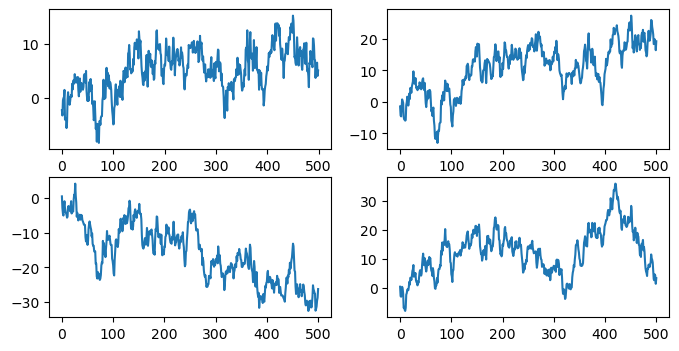

In [94]:
# Generate synthetic data based on the formula
T = 500 # Time steps
n = 10 # Initial dimension
d = 3 # Dimension after transformation

# Transition matrix
A = np.diag([1]*d)
# B = scipy.sparse.csc_matrix((d, n), dtype=None)
seed = 4
np.random.seed(seed)
B = np.random.rand(d, n)

# Two covariance matrices
cov = np.array([[0.0351,0.0017,0],[0,0.0289,0.0002],[0.0004,0,0.0298]])
w_t = np.random.multivariate_normal([0, 0, 0], cov @ cov.transpose(), size=T)
v_t = np.random.normal(0, 1, size = T)

# Initialization with 0 
theta = np.array([0.45,0.10,0.15])
z_t = np.zeros((T+1,d))
z_t[0,:] = np.random.normal(size=d)

# x_t, y = make_regression(n_samples=T, n_features=n, n_informative=d, noise=0, random_state=42)
x_t = np.random.normal(size=(T,n))
y_t = np.zeros(T)
# y_t[0] = theta @ z_t[0,:] + v_t[0]

# pca = PCA(n_components=d)  
# pca.fit(x_t)
# B = pca.components_

# Iterative generation
for t in range(T):
    z_t[t+1,:] = A @ z_t[t,:] + B @ x_t[t,:] + w_t[t,:]
    y_t[t] = theta @ z_t[t+1,:] + v_t[t]

# Prepare the traning and testing data
index = 300
X_train, X_test = x_t[:index,:], x_t[index:,:]
y_train, y_test = y_t[:index], y_t[index:] 


plt.rcParams['figure.figsize'] = (8,4)
fig, axes = plt.subplots(2,2)
axes[0,0].plot(y_t)
axes[0,1].plot(z_t[:,0])
axes[1,0].plot(z_t[:,1])
axes[1,1].plot(z_t[:,2])

True
------- Loglikelihood of No. 1 iteration -------
Total: 52378.41, Init: -950.47, Q: 38970.41, R: 14358.47

True
------- Loglikelihood of No. 2 iteration -------
Total: 56975.60, Init: -34.45, Q: 39612.28, R: 17397.77

True
------- Loglikelihood of No. 3 iteration -------
Total: 47708.04, Init: -14.81, Q: 27921.24, R: 19801.61

Running time : 1.6195


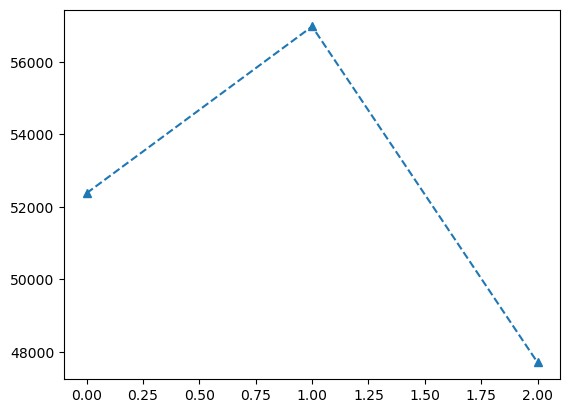

In [19]:
np.random.seed(21)
d = 3
pca = PCA(n_components=d)
pca.fit(X_train)
res = sm.OLS(y_train, (X_train @ pca.components_.T)).fit()
params = Parameters(
    init_theta = np.zeros((d, 1)),
    init_P = np.diag([100]*d), 
    A = np.diag([1]*d),
    B = np.random.rand(d, X_train.shape[1]),
    # B = pca.components_,
    Q = np.diag([0.01]*d),
    C = np.random.rand(1, d),
    # C = np.zeros((1, d)),
    # C = res.params[None,:],
    R = np.array([[0.01]]))
start_time = time.time()
results, likelihood = EMalgorithm(X_train, y_train, k=3, d=d, params=params)
end_time = time.time()
print("Running time : %.4f" % (end_time-start_time))
plt.plot(likelihood,'^--')


In [12]:
print('\nEstimated mu0: \n', results.theta0)
print('\nEstimated theta\n', results.C)
print('\nEstimated A\n', results.A)
print('\nEstimated Q\n', results.Q, '\n')
print(check_symmetric(results.Q))


Estimated mu0: 
 [[31.97160725]
 [33.3843147 ]
 [86.98313402]]

Estimated theta
 [[0.14554336 0.12178923 0.3627298 ]]

Estimated A
 [[ 9.98995508e-01 -2.68596457e-03  2.57249957e-03]
 [-2.97238426e-03  9.97023656e-01  5.56138760e-03]
 [-5.17272218e-03 -3.62055796e-04  1.00663924e+00]]

Estimated Q
 [[0.60005825 0.84185236 0.67846347]
 [0.84185236 1.38853633 0.87135185]
 [0.67846347 0.87135185 2.05834059]] 

True


In [13]:
print('Estimated B\n', results.B, '\n\n')
print('Estimated R: ', results.R)


Estimated B
 [[ 7.00748735e-01 -1.24865266e-01  4.50098223e-01  5.83127894e-02
  -7.02237044e-01  7.82049827e+00 -9.42237751e-01  6.36851220e-01
  -2.35596040e-01  5.03202525e+00 -3.00866652e-01  2.82218549e-01
  -5.21164504e+01 -2.37893778e+01  5.46813463e+00 -4.78022533e+00
   5.90877290e+00 -9.89550152e+00  6.16047963e-01  2.44588536e-01
   3.51980447e-01  3.39119292e-01  7.29093813e-02  9.90212234e-01
   1.92948811e-01  5.24599545e+01  3.66911879e+00  1.85552511e-01
  -1.64182387e-01  2.98038361e-01  1.49723046e-01  4.87432041e-01
   2.06672553e-01  1.85068979e-02  4.83220306e-01  6.36489517e-01
   8.14392408e-01  2.16771681e+01 -7.82749710e+00  6.09653162e+00
   1.43083923e+01 -6.07677484e+00 -7.49970280e+00 -1.60684129e+01
  -1.91466261e+01]
 [ 1.20199115e+00  3.95417705e-01  5.18363857e-01  7.99387509e-01
  -2.97411399e-01  5.48152596e+00 -8.87013779e-01  2.88502743e-01
   2.42785185e-02 -3.76630943e-01  1.29283442e-01 -3.16736380e-01
   5.90084233e+00 -2.02048714e+01  5.5250710

OLS rmse 0.0618, OLS mae 0.0507
EM train rmse 0.0251, test rmse 0.0314
EM train mae 0.0151, test mae 0.0257
Off rmse 0.0466, Off mae 0.0386


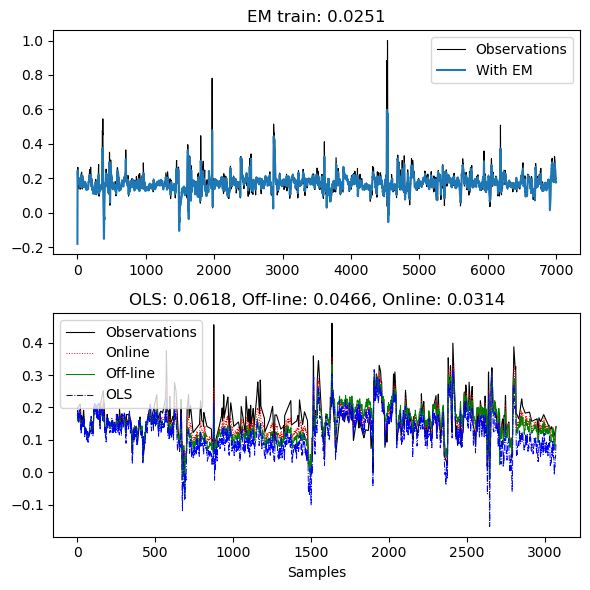

In [22]:
ols_res = sm.OLS(y_train, X_train).fit()
ytehat_ols = ols_res.predict(X_test)
print('OLS rmse %.4f, OLS mae %.4f' % (rmse(y_test, ytehat_ols),mae(y_test, ytehat_ols)))

KF_em = KalmanFilter(X_train, y_train, results, d)
ytrhat_em, ytehat_em, ytehat_off = KalmanFilterPred(X_test, y_test, KF_em, results.Q, results.R, d)
print('EM train rmse %.4f, test rmse %.4f' % (rmse(y_train, ytrhat_em),rmse(y_test, ytehat_em)))
print('EM train mae %.4f, test mae %.4f' % (mae(y_train, ytrhat_em),mae(y_test, ytehat_em)))

# plt.rcParams['figure.figsize'] = (10,4)
fig, axes = plt.subplots(2,1,figsize = [6,6])
axes[0].plot(y_train, 'k', linewidth=0.8, label='Observations')
axes[0].plot(ytrhat_em, label='With EM')
axes[0].set_title('EM train: %.4f' % rmse(y_train, ytrhat_em))
axes[0].legend()

axes[1].plot(y_test, 'k', linewidth=0.8, label='Observations')
axes[1].plot(ytehat_em, 'r:', linewidth=0.7, label='Online')
axes[1].plot(ytehat_off,'g', linewidth=0.7, label='Off-line')
axes[1].plot(ytehat_ols, 'b-.', linewidth=0.7, label='OLS')
axes[1].set_title('OLS: %.4f, Off-line: %.4f, Online: %.4f' % (rmse(y_test, ytehat_ols),rmse(y_test, ytehat_off),rmse(y_test, ytehat_em)))
axes[1].set_xlabel('Samples')
print('Off rmse %.4f, Off mae %.4f' % (rmse(y_test, ytehat_off),mae(y_test, ytehat_off)))
plt.legend()
plt.tight_layout()

data = {'Observations': y_test, 'LDS': ytehat_em, 'LDS Off': ytehat_off}
df_result = pd.DataFrame(data)
# relative_path = os.path.join(os.getcwd(), 'Variables', 'Debutanizer-MV2.csv')
# relative_path = os.path.join(os.getcwd(), 'Variables', 'MeltIndex-MV2.csv')
relative_path = os.path.join(os.getcwd(), 'Variables', 'Sulfur-MV2.csv')
df_result.to_csv(relative_path, index=False)


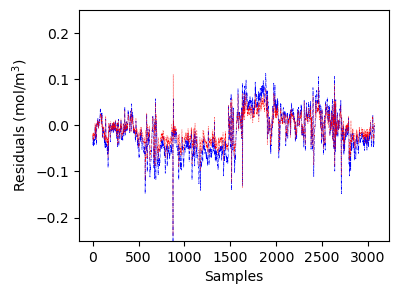

In [14]:
fig, axes = plt.subplots(figsize=(4,3))
# axes.plot(y_test, 'k-', linewidth=0.8, label='Measurements')
axes.plot(ytehat_off-y_test, 'b-.', linewidth=0.4, label='Offline prediction')
axes.plot(ytehat_em-y_test, 'r:', linewidth=0.4, label='Online prediction')
# axes.set_ylabel('Butane content (%)')
# axes.set_ylabel('Melt index (g/10 min)')
axes.set_ylabel(r'Residuals (mol/m$^3$)')
axes.set_xlabel('Samples')
# axes.set_ylim(-0.2,0.8)
# axes.set_ylim(-0.03,0.28)
axes.set_ylim(-0.25,0.25)
# axes.legend()
relative_path = os.path.join(os.getcwd(), 'Figures', 'SulfurM2.png')
plt.savefig(relative_path, dpi=600, bbox_inches='tight')